# Analysis broken down:

**Goal:** Use reviews to perform binary classification on whether a vintage is either average/good or best in class.

**Target variable Rating has two classes: 0 (3.0-4.0 starts) if average and 1 (4.5-5.0 stars) if great.**

**Make class split based on 75 percentile**.

- Preprocess text.
-- Filter english, remove punctuations emojis etc.
-- Keep numbers?

- Tokenization
-- Use Spacy to tokenize.
-- Remove stop words, lemmatize, only if text pos_ is ['NOUN', 'PROPN', 'ADJ', 'ADV'].
-- Consider adding verbs?

- **Nice to have: Word counts**. Look at which words overlap the most and which words overlap the least between classes.

- Dictionary and BoW representation
-- Based on counts and tfidf.
-- Sklearn does a very poor job at this, therefore Gensim is used.

-- Train regular ML models on BoW

# Preprocessing of reviews

In [ ]:
%%capture
! pip install langdetect
! pip install emot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/My Drive/CBS/DSBA/project_vivino/Data/finalized_data/all_reviews_and_users.csv', index_col='review_id')
df.head(3)

,Unnamed: 0,Unnamed: 0.1,rating,note,created_at,vintage_id,wine_id,user_id,seo_name,ratings_count,reviews_count,ratings_sum,is_featured,followers_count,followings_count,average_ratings,net_follower_score,types
review_id,,,,,,,,,,,,,,,,,,
65581154,0,0,3.0,"Easy to drink, tastes like a lot of berries mi...",2017-04-01T08:54:16.000Z,22505105,1577018,1404201,valzevul,119,108,424.5,False,9,5,3.567227,1.800000,Red wine
157698730,1,1,4.5,My favorite so far from Pulenta Estate. Cherry...,2020-03-22T00:09:21.000Z,22124179,1153456,3278342,alexis-riv,782,600,3225.0,False,160,257,4.124041,0.622568,Red wine
129034690,2,2,4.5,"Great structure and concentration, with raspbe...",2019-06-07T22:55:23.000Z,22124179,1153456,223051,bernardof,1355,1077,5078.5,False,158,165,3.747970,0.957576,Red wine


In [ ]:
df['net_follower_score'] = df['net_follower_score'].replace(np.inf, np.nan)
df = df[['note', 'types', 'rating', 'average_ratings', 'net_follower_score']].dropna(how='any')
#df = df.sample(1000, random_state=42)

display(df.head(3))
[print(i,row) for i,row in enumerate(df['note'][:5])]

,note,types,rating,average_ratings,net_follower_score
review_id,,,,,
65581154,"Easy to drink, tastes like a lot of berries mi...",Red wine,3.0,3.567227,1.800000
157698730,My favorite so far from Pulenta Estate. Cherry...,Red wine,4.5,4.124041,0.622568
129034690,"Great structure and concentration, with raspbe...",Red wine,4.5,3.747970,0.957576


0 Easy to drink, tastes like a lot of berries mixed with a decent grape juice 
1 My favorite so far from Pulenta Estate. Cherry 🍒, plums, oak and spice at the end. Balanced tannins with not overpowering acidity. Cheers 🍷🍷🍷🍷🍷
2 Great structure and concentration, with raspberries, blueberries, licorice, lavander and dark chocolate. Full bodied with good balance and rosted expresso aftertaste.
3 As said before this wine is spectacular, one of the best gems of Argentina 🇦🇷.
Highly recommended.
4 Smokey and peppery medium acidity mild dark fruits. Beautiful Malbec!


[None, None, None, None, None]

## Language detection:

Overall, the language detection algorithm has some misclassifications as it is mislabelling english reviews as other languages. However, it is quite good with spanish languages, and it is only 373 observations so we will remove all these.

In [ ]:
from langdetect import detect, detect_langs

df['lang'] = df.apply(lambda row: detect(row['note']), axis=1)

df[df['lang'] != 'en']
df = df[df['lang'] == 'en'] # Only keep english reviews

#df.to_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/reviews_lang_full.csv')

## Remove punctuation and Emojis to text

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/reviews_lang_full.csv')

In [ ]:
import spacy
import re
import string
nlp = spacy.load('en')

# Remove punctuation
exclude = set(string.punctuation)
df['note_clean'] = df.apply(lambda row:''.join(ch for ch in row['note'] if ch not in exclude), axis=1)

# Function to remove emoji.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#passing the emoji function to 'text_rare'
df['note_clean'] = df['note_clean'].apply(remove_emoji)


from emot.emo_unicode import UNICODE_EMO, EMOTICONS
# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)
remove_emoticons("Hello :-)")
# applying remove_emoticons to 'text_rare'
df['note_clean'] = df['note_clean'].apply(remove_emoticons)


# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


#Passing the function to 'text_rare'
df['note_clean'] = df['note_clean'].apply(remove_urls)


df.head(2)

,review_id,note,types,rating,average_ratings,net_follower_score,lang,note_clean
0,65581154,"Easy to drink, tastes like a lot of berries mi...",Red wine,3.0,3.567227,1.800000,en,Easy to drink tastes like a lot of berries mix...
1,157698730,My favorite so far from Pulenta Estate. Cherry...,Red wine,4.5,4.124041,0.622568,en,My favorite so far from Pulenta Estate Cherry ...


## Create bins

,count,mean,std,min,25%,50%,75%,max
ratings_cut,,,,,,,,
2,3310.0,2.238973,0.407868,1.0,2.0,2.5,2.5,2.5
0,95902.0,3.755094,0.342555,3.0,3.5,4.0,4.0,4.0
1,22381.0,4.583397,0.186400,4.5,4.5,4.5,4.5,5.0


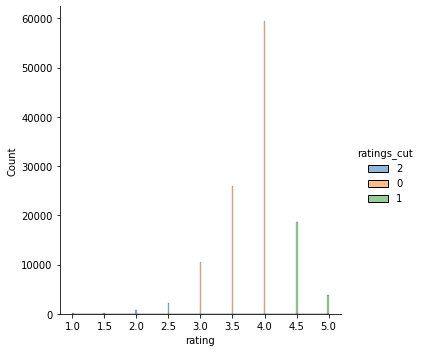

In [ ]:
cut_labels = [2,0,1] # Worst wines map to 2, regular to 0 and great to 1
cut_bins = [0, 2.5, 4.0, 5.0]
df['ratings_cut'] = pd.cut(df['rating'], bins=cut_bins, labels=cut_labels)

display(df.groupby('ratings_cut')['rating'].describe() )
sns.displot(df, x="rating", hue="ratings_cut")

In [ ]:
df = df[df['ratings_cut'] != 2]

ratings_dist = np.bincount(df['ratings_cut'])
class_weight = {0: (1 / ratings_dist[0]),
                1: (1 / ratings_dist[1] )
                }

## Visualize word dependencies & Tokenize

In [ ]:
text_list = []

for text in nlp.pipe(df['note_clean']):
    text_info = [(token.lemma_, token.pos_, token.dep_) for token in text if not token.is_stop and token.pos_ != 'SPACE']
    text_list.append(text_info)

# Transform to DF
word_df = pd.DataFrame([t for lst in text_list for t in lst], columns = ['token', 'pos', 'dep'])

# Get a count of token occurence and add that as column.

word_df = pd.merge(word_df, word_df.groupby('token').count()['pos'],
                   how='left', left_on='token', right_index=True).rename({'pos_x': 'pos',
                                                                          'pos_y': 'token_count'}, axis=1)
word_df = word_df.drop_duplicates(subset='token').sort_values('token_count', ascending=False)

In [ ]:
#word_df.to_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/word_df_full.csv')
print('Number of unique tokens:', len(word_df['token'].unique()) )  
word_df.head(10)

Number of unique tokens: 60274


,token,pos,dep,token_count
40,wine,NOUN,nsubj,37295
53,fruit,NOUN,dobj,33475
34,good,ADJ,amod,29889
138,finish,NOUN,ROOT,25536
64,nose,NOUN,pobj,22183
59,red,NOUN,ROOT,21455
63,cherry,NOUN,ROOT,21212
20,tannin,NOUN,ROOT,20613
111,nice,ADJ,amod,18838
22,acidity,NOUN,compound,17436


In [ ]:
word_df.groupby('pos').max()

,token,dep,token_count
pos,,,
ADJ,🧻,xcomp,29889
ADP,🦆,punct,2237
ADV,⏺,xcomp,6565
CCONJ,„,punct,1797
DET,•this,punct,40
INTJ,🦵,pobj,1188
NOUN,🧼,xcomp,37295
NUM,🦦,quantmod,2146
PART,🥨,punct,3126


In [ ]:
word_df.head(10).to_latex(index=False)

'\\begin{tabular}{lllr}\n\\toprule\n   token &   pos &       dep &  token\\_count \\\\\n\\midrule\n    wine &  NOUN &     nsubj &        37295 \\\\\n   fruit &  NOUN &      dobj &        33475 \\\\\n    good &   ADJ &      amod &        29889 \\\\\n  finish &  NOUN &      ROOT &        25536 \\\\\n    nose &  NOUN &      pobj &        22183 \\\\\n     red &  NOUN &      ROOT &        21455 \\\\\n  cherry &  NOUN &      ROOT &        21212 \\\\\n  tannin &  NOUN &      ROOT &        20613 \\\\\n    nice &   ADJ &      amod &        18838 \\\\\n acidity &  NOUN &  compound &        17436 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Tokenization

In [ ]:
tokens = []

for text in nlp.pipe(df['note_clean']):
    text_tok = [token.lemma_.lower() for token in text if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] and not token.is_stop]
    tokens.append(text_tok)

df['tokens'] = tokens
df['token_string'] = df['tokens'].map(lambda row: ' '.join(row))

In [ ]:
df.head(3)

,review_id,note,types,rating,average_ratings,net_follower_score,lang,note_clean,ratings_cut,tokens,token_string
0,65581154,"Easy to drink, tastes like a lot of berries mi...",Red wine,3.0,3.567227,1.800000,en,Easy to drink tastes like a lot of berries mix...,0,"[easy, taste, lot, berry, decent, grape, juice]",easy taste lot berry decent grape juice
1,157698730,My favorite so far from Pulenta Estate. Cherry...,Red wine,4.5,4.124041,0.622568,en,My favorite so far from Pulenta Estate Cherry ...,1,"[favorite, far, pulenta, estate, cherry, plum,...",favorite far pulenta estate cherry plum oak sp...
2,129034690,"Great structure and concentration, with raspbe...",Red wine,4.5,3.747970,0.957576,en,Great structure and concentration with raspber...,1,"[great, structure, concentration, raspberry, b...",great structure concentration raspberry bluebe...


In [ ]:
#df.to_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/tokenized_full.csv')

In [ ]:
[print(t) for t in df['token_string'][:5]]

easy taste lot berry decent grape juice
favorite far pulenta estate cherry plum oak spice end balanced tannin acidity cheer
great structure concentration raspberry blueberry lavander dark chocolate good balance expresso aftertaste
wine spectacular good gem argentina highly
smokey peppery medium acidity mild dark fruit beautiful malbec


[None, None, None, None, None]

# Dictionary and BoW

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/tokenized_full.csv').drop(columns='Unnamed: 0')

In [ ]:
%%capture
!pip install gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel


!pip install -qq pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
pyLDAvis.enable_notebook()

from gensim.models import LdaMulticore
from gensim.matutils import corpus2dense

## SkLearn shit example

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['token_string'])

pd.DataFrame(X.A, columns=vectorizer.get_feature_names()).head(2)
'''

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nvectorizer = TfidfVectorizer()\nX = vectorizer.fit_transform(df['token_string'])\n\npd.DataFrame(X.A, columns=vectorizer.get_feature_names()).head(2)\n"

## CountVector

In [ ]:
dictionary = Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=1000) # No tokens that appear in less than 10 reviews
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

#df['bow'] = df["tokens"].map(dictionary.doc2bow) # Alternative way of generating corpus

In [ ]:
col_names = list()
for k, v in dictionary.token2id.items():
    col_names.append(k)

count_df = pd.DataFrame(corpus2dense(corpus, num_terms=len(dictionary)).T,
                         columns=col_names)

count_df

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


,berry,decent,easy,grape,juice,lot,taste,acidity,balanced,cheer,cherry,end,estate,far,favorite,oak,plum,spice,tannin,aftertaste,balance,blueberry,chocolate,concentration,dark,good,great,raspberry,structure,argentina,gem,highly,spectacular,wine,beautiful,fruit,malbec,medium,mild,peppery,...,offdry,sea,weak,zinfandel,iron,winter,away,hints,tannine,work,river,offering,compote,zin,barrique,goodness,overtone,brick,tartness,pomegranate,hazelnut,option,cacao,sangiovese,normally,unusual,finesse,barolo,fennel,guava,oregon,nebbiolo,sense,australia,barbera,tuscan,brunello,cava,beaujolais,marlborough
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118278,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118281,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TFIDF-Vector

In [ ]:
# Apply tfidf to corpus
corpus_tfidf = TfidfModel(corpus)[corpus]
tfidf_df = pd.DataFrame(corpus2dense(corpus_tfidf, num_terms=len(dictionary)).T,
                         columns=col_names)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [ ]:
#tfidf_df.to_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/tfidf_full.csv')
#count_df.to_csv('/content/drive/MyDrive/CBS/DSBA/project_vivino/NLP/count_full.csv')

# Apply ML models

### Model selection

## Rule-based models

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


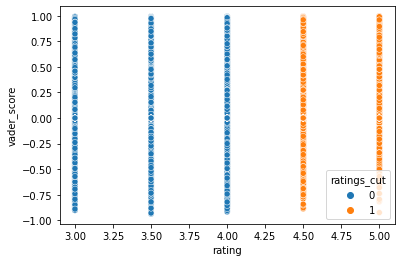

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

vader = SentimentIntensityAnalyzer()

df['vader_score'] = df.apply(lambda row: vader.polarity_scores(row['note'])['compound'], axis=1)

#sns.scatterplot(y=df['vader_score'], x=df['rating'].astype(float), hue=df['ratings_cut'].astype(int) )

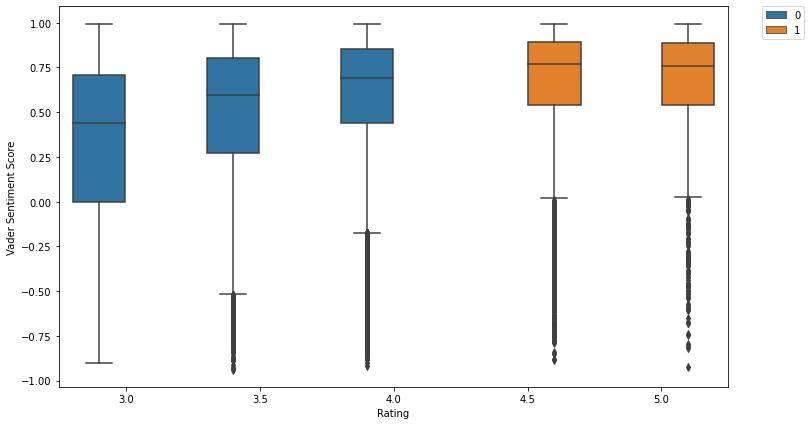

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(y=df['vader_score'], x=df['rating'].astype(float), hue=df['ratings_cut'].astype(int))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_ylabel('Vader Sentiment Score')
ax.set_xlabel('Rating');

## Feature-based models

Currently not using the same train/test split as Vader

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = tfidf_df.to_numpy()
y = df['ratings_cut'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [ ]:
class_imbalance = ratings_dist[0] / ratings_dist[1]

#Instantiate models
log_clf = LogisticRegression()
el_clf = ElasticNetCV()
tree_clf = DecisionTreeClassifier()
rnf_clf = RandomForestClassifier(n_estimators=500)
xgb_clf = XGBClassifier(scale_pos_weight=class_imbalance)

# Dominant model
print('Dominant score:', round(np.bincount(y)[0] / len(y), 4))

# Logistic regression
log_clf.fit(X_train, y_train)
print("Logistic score: ", log_clf.score(X_test,y_test))

# Elastic net
el_clf.fit(X_train, y_train)
print("EL score: ", el_clf.score(X_test,y_test))

# Tree model with CV
parameters_tree = {"max_depth": [3,10,20, None],
                   "max_leaf_nodes":[3,5,10,None]}

grid_tree = GridSearchCV(tree_clf, parameters_tree, cv = 5, scoring='recall')
tree_clf = grid_tree.fit(X_train, y_train).best_estimator_
print("Decision tree score: ", tree_clf.score(X_test,y_test))


# RF with CV
parameters_rnf = {'bootstrap': [True, False],
 'max_depth': [3,10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500]}

#grid_rnf = GridSearchCV(rnf_clf, parameters_rnf,cv = 5)
#rnf_clf = grid_rnf.fit(X_train, y_train).best_estimator_
rnf_clf.fit(X_train, y_train)

print("RandomForest score: ", rnf_clf.score(X_test,y_test))

# XGBoost
xgb_clf.fit(X_train, y_train)
print('XGB score:', xgb_clf.score(X_test, y_test))

Dominant score: 0.8108


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic score:  0.8289723971763114
EL score:  0.1739027791189951
Decision tree score:  0.7520818362429725


KeyboardInterrupt: ignored

In [ ]:
_ = RandomForestClassifier(n_estimators=500, class_weight='balanced')
_.fit(X_train, y_train)
print("RandomForest score: ", _.score(X_test,y_test))

RandomForest score:  0.8052631578947368


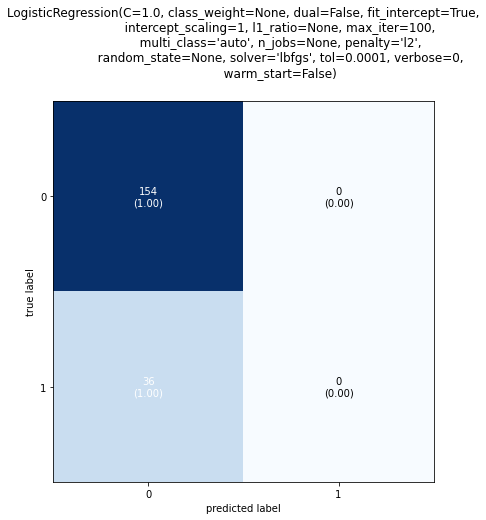

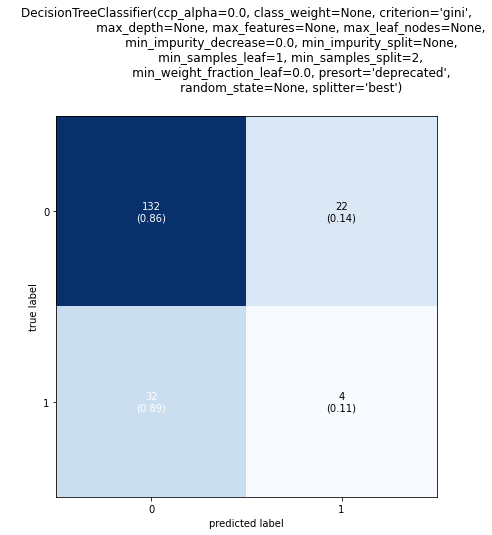

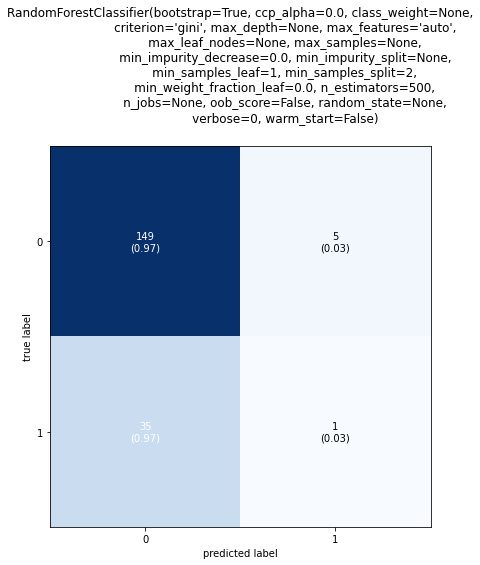

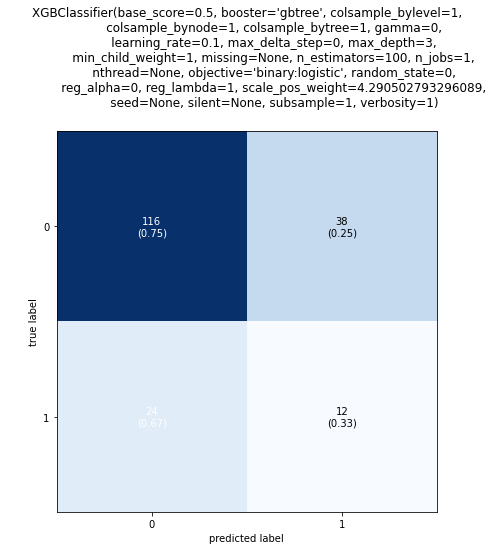

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Loop through models to compute confusion matrix and plot it
for model in [log_clf, tree_clf, rnf_clf, xgb_clf]:
    conf_mat = confusion_matrix(y_test , model.predict(X_test))
    plot_confusion_matrix(conf_mat,
                          show_absolute=True,
                          show_normed=True, figsize=(12,7))
    plt.title(str(model))

## Feature based models sliced based on Vader

From the Vader analysis is seems very few observations from class=1 is present with a sentiment score below 0.25.

In the following we filter the dataset based on this.

In [ ]:
df[df['vader_score'] < 0.0].groupby('ratings_cut').count()

,note,types,rating,average_ratings,net_follower_score,lang,note_clean,tokens,token_string,vader_score
ratings_cut,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0
0,43,43,43,43,43,43,43,43,43,43
1,1,1,1,1,1,1,1,1,1,1


In [ ]:
tfidf_df.index = df.index
tfidf_df['vader_score'] = df['vader_score']


In [ ]:
X = tfidf_df[tfidf_df['vader_score'] > 0.25].drop('vader_score', axis=1).to_numpy()
y = df[df['vader_score'] > 0.25]['ratings_cut'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [ ]:
#Instantiate models
log_clf = LogisticRegression()
el_clf = ElasticNetCV()
tree_clf = DecisionTreeClassifier()
rnf_clf = RandomForestClassifier(n_estimators=500)
xgb_clf = XGBClassifier(scale_pos_weight=class_imbalance)

# Dominant model
print('Dominant score:', round(np.bincount(y)[0] / len(y), 4))

# Logistic regression
log_clf.fit(X_train, y_train)
print("Logistic score: ", log_clf.score(X_test,y_test))

# Elastic net
el_clf.fit(X_train, y_train)
print("EL score: ", el_clf.score(X_test,y_test))

# Tree model with CV
parameters_tree = {"max_depth": [3,10,20, None],
                   "max_leaf_nodes":[3,5,10,None]}

grid_tree = GridSearchCV(tree_clf, parameters_tree, cv = 5)
tree_clf = grid_tree.fit(X_train, y_train).best_estimator_
print("Decision tree score: ", tree_clf.score(X_test,y_test))


# RF with CV
parameters_rnf = {'bootstrap': [True, False],
 'max_depth': [3,10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500]}

#grid_rnf = GridSearchCV(rnf_clf, parameters_rnf,cv = 5)
#rnf_clf = grid_rnf.fit(X_train, y_train).best_estimator_
rnf_clf.fit(X_train, y_train)

print("RandomForest score: ", rnf_clf.score(X_test,y_test))

Dominant score: 0.7952
Logistic score:  0.8227848101265823
EL score:  0.03225788359677706
Decision tree score:  0.7784810126582279
RandomForest score:  0.7974683544303798


# Topic modelling

## TFIDF PYLDAVIS

In [ ]:
%%capture

df_subset = df[df['ratings_cut'] == 0]
dictionary = Dictionary(df_subset['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5) # No tokens that appear in less than 10 reviews
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=3, workers = 4, passes=10)

# Let's Visualize
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

In [ ]:
pyLDAvis.display(lda_display)

In [ ]:
%%capture

df_subset = df[df['ratings_cut'] == 1]
dictionary = Dictionary(df_subset['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5) # No tokens that appear in less than 10 reviews
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=3, workers = 4, passes=10)

# Let's Visualize
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

In [ ]:
pyLDAvis.display(lda_display)

# Counting words

Potential step in preprocessing and better understanding of models.

**To do:**
1. Count all words by each rating class
2. Graph the words with most and the least overlap between classes.
3. Tune models so they 1) only exclude most common overlapping words and 2) only include least overlapping words. 

### By rating

In [ ]:
# Function for drawing graphs
def graph(word_frequency, sent):
    n=len(word_frequency)
    labels = word_frequency[0][:n].index
    title = "Word Frequency for %s" %sent
    
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(n), word_frequency[0][:n], width = 0.8, color = sns.color_palette("mako"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(n), labels, rotation=90, size=10);
    plt.xlabel(f"{n} most frequent words", size=10);
    plt.ylabel("Frequency", size=10);

    plt.title(title, size=15)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()



from nltk.corpus import stopwords
nltk.download('stopwords')

# Storing stopwords of english language from nltk library
sw = set(stopwords.words("english"))

sw_new = []   #Empty list for stroring
for i in sw:
    sw_new.append(i)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


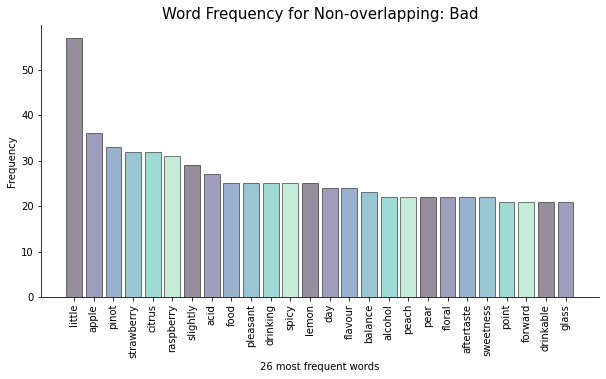

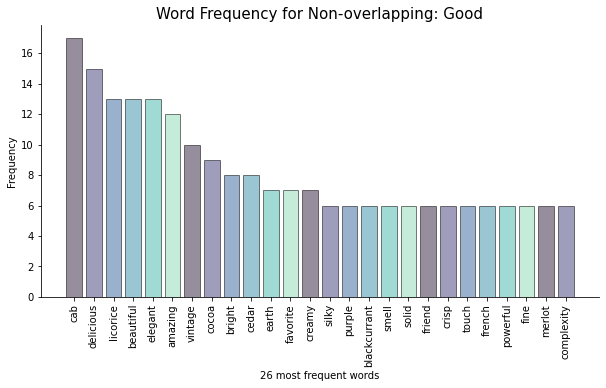

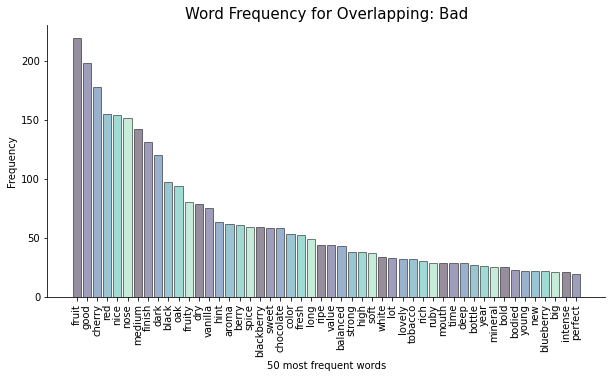

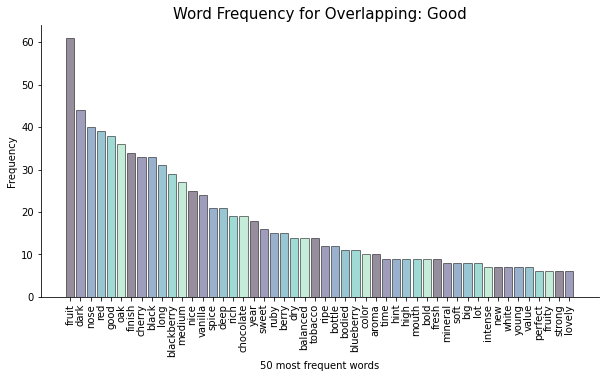

In [ ]:
def n_largest_df(df, n_largest, label):
    df = df[df['ratings_cut'] == label].T.sum(axis=1).drop('ratings_cut').nlargest(n_largest)
    return pd.DataFrame(df)

def overlap_fun(df, n_words):
    ''' Return a list of top n overlapping words between classes '''
    words_class_0 = n_largest_df(df, n_words, 0).index
    words_class_1 = n_largest_df(df, n_words, 1).index

    return list(set(words_class_0) & set(words_class_1))

count_df['ratings_cut'] = df['ratings_cut'].astype(int).to_numpy()


overlap = overlap_fun(count_df, 100)
non_overlap = list(n_largest_df(count_df, 100, 0).drop(overlap).index)


# Least overlapping words
graph(n_largest_df(count_df, 100, 0).drop(overlap), 'Non-overlapping: Bad')
graph(n_largest_df(count_df, 100, 1).drop(overlap), 'Non-overlapping: Good')


# Overlapping words
graph(n_largest_df(count_df, 100, 0).loc[overlap[:50]].sort_values(0, ascending=False), 'Overlapping: Bad')
graph(n_largest_df(count_df, 100, 1).loc[overlap[:50]].sort_values(0, ascending=False), 'Overlapping: Good')

## Tune models using word counts

In [ ]:
overlap = overlap_fun(count_df, 200)
non_overlap = list(n_largest_df(count_df, 200, 0).drop(overlap).index)

X = tfidf_df.drop(overlap, axis=1).to_numpy()
y = df['ratings_cut'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [ ]:
#Instantiate models
log_clf = LogisticRegression()
el_clf = ElasticNetCV()
tree_clf = DecisionTreeClassifier()
rnf_clf = RandomForestClassifier(n_estimators=500)
xgb_clf = XGBClassifier(scale_pos_weight=class_imbalance)

# Dominant model
print('Dominant score:', round(np.bincount(y)[0] / len(y), 4))

# Logistic regression
log_clf.fit(X_train, y_train)
print("Logistic score: ", log_clf.score(X_test,y_test))

# Elastic net
el_clf.fit(X_train, y_train)
print("EL score: ", el_clf.score(X_test,y_test))

# Tree model with CV
parameters_tree = {"max_depth": [3,10,20, None],
                   "max_leaf_nodes":[3,5,10,None]}

grid_tree = GridSearchCV(tree_clf, parameters_tree, cv = 5, scoring='recall')
tree_clf = grid_tree.fit(X_train, y_train).best_estimator_
print("Decision tree score: ", tree_clf.score(X_test,y_test))


# RF with CV
parameters_rnf = {'bootstrap': [True, False],
 'max_depth': [3,10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500]}

#grid_rnf = GridSearchCV(rnf_clf, parameters_rnf,cv = 5)
#rnf_clf = grid_rnf.fit(X_train, y_train).best_estimator_
rnf_clf.fit(X_train, y_train)

print("RandomForest score: ", rnf_clf.score(X_test,y_test))

# XGBoost
xgb_clf.fit(X_train, y_train)
print('XGB score:', xgb_clf.score(X_test, y_test))

Dominant score: 0.811
Logistic score:  0.8105263157894737
EL score:  0.0636365239136173
Decision tree score:  0.6947368421052632
RandomForest score:  0.7210526315789474
XGB score: 0.6421052631578947


In [ ]:
X = tfidf_df[overlap].to_numpy()
y = df['ratings_cut'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

#Instantiate models
log_clf = LogisticRegression()
el_clf = ElasticNetCV()
tree_clf = DecisionTreeClassifier()
rnf_clf = RandomForestClassifier(n_estimators=500)

# Dominant model
print('Dominant score:', round(np.bincount(y)[0] / len(y), 4))

# Logistic regression
log_clf.fit(X_train, y_train)
print("Logistic score: ", log_clf.score(X_test,y_test))

# Elastic net
el_clf.fit(X_train, y_train)
print("EL score: ", el_clf.score(X_test,y_test))

# Tree model with CV
parameters_tree = {"max_depth": [3,10,20, None],
                   "max_leaf_nodes":[3,5,10,None]}

grid_tree = GridSearchCV(tree_clf, parameters_tree, cv = 5, scoring='recall')
tree_clf = grid_tree.fit(X_train, y_train).best_estimator_
print("Decision tree score: ", tree_clf.score(X_test,y_test))


# RF with CV
parameters_rnf = {'bootstrap': [True, False],
 'max_depth': [3,10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500]}

#grid_rnf = GridSearchCV(rnf_clf, parameters_rnf,cv = 5)
#rnf_clf = grid_rnf.fit(X_train, y_train).best_estimator_
rnf_clf.fit(X_train, y_train)

print("RandomForest score: ", rnf_clf.score(X_test,y_test))

# XGBoost
xgb_clf.fit(X_train, y_train)
print('XGB score:', xgb_clf.score(X_test, y_test))

Dominant score: 0.811
Logistic score:  0.8105263157894737
EL score:  0.031227069761530668
Decision tree score:  0.7157894736842105
RandomForest score:  0.7842105263157895
XGB score: 0.7052631578947368
